### miniGRU的并行公式推导

GRU的隐藏层更新公式如下：
$$ h_t = (1-z_t) \odot h_{t-1} + z_t \odot \widetilde{h}_t$$

miniGRU已经将模型修改成为了时间独立的了，因此可以做并行计算了。
在并行算法中，非常适合处理 $v_t=a_tv_{t-1}+b_t$样子的公式

所以，我们可以做如下对应：
$$ a_t := (1-z_t) $$
$$ b_t := z_t \odot \widetilde{h}_t $$
$$ v_t := h_t $$


#### 下面开始数学归纳
我们有一个初始状态$h_0$
可得：

$h_1 = a_1 * h_0 + b_1$

$h_2 = a_2 * h_1 + b_2$  ====>即： $h_2 = a_1a_2h_0 + a_2b_1 + b_2$

$h_3 = a_3 * h_2 + b_3$  ====>即： $h_3 = a_1a_2a_3h0 + a_2a_3b_1 + a_3b_2 + b_3$

<br/>
我们用 $prod(n)$表示a0 * a1 *** an   即： 
 

$$ \prod_{i=1}^{n} a_i $$


因此上面得状态情况可以写成公式：
$$h_i = pord(n) * h_0 + \sum_{j=1}^{i} \frac{prod(n)}{prod(j)} * b_j$$

即：

$$h_i = (\prod_{i=1}^{n} a_i) * h_0 + \sum_{j=1}^{i} \frac{\prod_{i=1}^{n} a_i}{\prod_{k=1}^{j} a_k} * b_j$$

$ \prod_{i=0}^{n} a_i $ 可以提出来，结果表示为：

$$h_i = \prod_{i=1}^{n} a_i * (h_0 + \sum_{j=1}^{i} \frac{b_j}{\prod_{k=1}^{j} a_k}) $$


#### 仔细观察发现数据的范围：

* h0是我们需要传入的数据

* 输出是h1到hn

* a的范围是a1到an

* b的范围是b1到bn


所以，我们不妨添加一个a0为1，添加一个b0为h0

这是很合理的，因为a0,h0,b0合起来可以就是用来生成h0的，所以$h_0 = a_0 * h_{-1} + b_0$

a0不能设置为0，因为如果设置为0，就会影响到后面的累乘，所以只能是1

这样就可以让公式进一步简化：
$$h_i = \prod_{i=0}^{n} a_i * (\frac{b_0}{\prod_{k=0}^{0} a_k} + \sum_{j=1}^{i} \frac{b_j}{\prod_{k=0}^{j} a_k}) $$

即：

$$h_i = \prod_{i=0}^{n} a_i * (\sum_{j=0}^{i} \frac{b_j}{\prod_{k=0}^{j} a_k}) $$


#### 为了保证大数的准确性，我们需要在log空间上进行操作

此时：

$$ a_\star = log(\prod_{i=0}^{n} a_i ) = \sum_{i=0}^{n} log(a_i)$$
$$ b_\star = log(\frac{b_j}{\prod_{k=0}^{j} a_k}) = \frac{log(b_j)}{a_{\star j}} = log(b_j) - a_{\star j}$$

torch.logcumsumexp方法的功能如下：
$$ y_{ij} = log \sum_{j=0}^{i} exp(x_{ij})$$

因此：

$$ \sum_{j=0}^{i} \frac{b_j}{\prod_{k=0}^{j} a_k} = torch.logcumsumexp(b_\star)$$


至此，公式推导完毕，torch的代码如下：
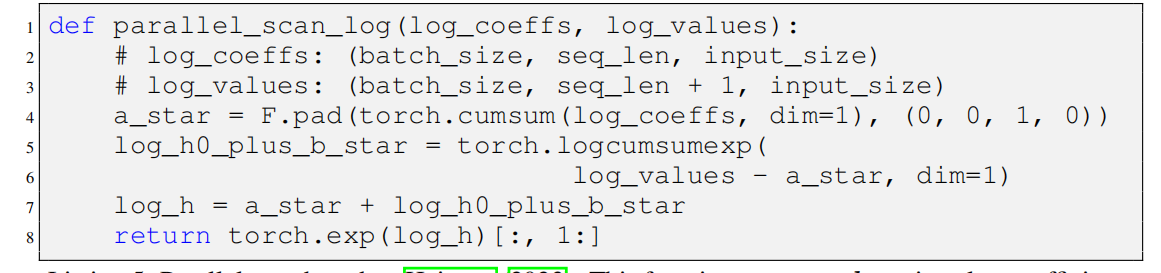

In [856]:
import random

import torch

import collections

from d2l import torch as d2l

import math

import re

from torch import nn

from torch.nn import functional as F



d2l.DATA_HUB['time_machine'] = (d2l.DATA_URL + 'timemachine.txt',

                                                                '090b5e7e70c295757f55df93cb0a180b9691891a')



def read_time_machine():    #@save

        """将时间机器数据集加载到文本行的列表中"""

        with open(d2l.download('time_machine'), 'r') as f:

                lines = f.readlines()

        return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]

def tokenize(lines, token='word'):    #@save

        """将文本行拆分为单词或字符词元"""

        if token == 'word':

                return [line.split() for line in lines]

        elif token == 'char':

                return [list(line) for line in lines]

        else:

                print('错误：未知词元类型：' + token)

class Vocab:    #@save

        """文本词表"""

        def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):

                if tokens is None:

                        tokens = []

                if reserved_tokens is None:

                        reserved_tokens = []

                # 按出现频率排序

                counter = count_corpus(tokens)

                self._token_freqs = sorted(counter.items(), key=lambda x: x[1],

                                                                        reverse=True)

                # 未知词元的索引为0

                self.idx_to_token = ['<unk>'] + reserved_tokens

                self.token_to_idx = {token: idx

                                                            for idx, token in enumerate(self.idx_to_token)}

                for token, freq in self._token_freqs:

                        if freq < min_freq:

                                break

                        if token not in self.token_to_idx:

                                self.idx_to_token.append(token)

                                self.token_to_idx[token] = len(self.idx_to_token) - 1



        def __len__(self):

                return len(self.idx_to_token)



        def __getitem__(self, tokens):

                if not isinstance(tokens, (list, tuple)):

                        return self.token_to_idx.get(tokens, self.unk)

                return [self.__getitem__(token) for token in tokens]



        def to_tokens(self, indices):

                if not isinstance(indices, (list, tuple)):

                        return self.idx_to_token[indices]

                return [self.idx_to_token[index] for index in indices]



        @property

        def unk(self):    # 未知词元的索引为0

                return 0



        @property

        def token_freqs(self):

                return self._token_freqs



def count_corpus(tokens):    #@save

        """统计词元的频率"""

        # 这里的tokens是1D列表或2D列表

        if len(tokens) == 0 or isinstance(tokens[0], list):

                # 将词元列表展平成一个列表

                tokens = [token for line in tokens for token in line]

        return collections.Counter(tokens)

def load_corpus_time_machine(max_tokens=-1):    #@save

        """返回时光机器数据集的词元索引列表和词表"""

        lines = read_time_machine()

        tokens = tokenize(lines, 'char')

        vocab = Vocab(tokens)

        # 因为时光机器数据集中的每个文本行不一定是一个句子或一个段落，

        # 所以将所有文本行展平到一个列表中

        corpus = [vocab[token] for line in tokens for token in line]

        if max_tokens > 0:

                corpus = corpus[:max_tokens]

        return corpus, vocab

def seq_data_iter_random(corpus, batch_size, num_steps):    #@save

        """使用随机抽样生成一个小批量子序列"""

        # 从随机偏移量开始对序列进行分区，随机范围包括num_steps-1

        corpus = corpus[random.randint(0, num_steps - 1):]

        # 减去1，是因为我们需要考虑标签

        num_subseqs = (len(corpus) - 1) // num_steps

        # 长度为num_steps的子序列的起始索引

        initial_indices = list(range(0, num_subseqs * num_steps, num_steps))

        # 在随机抽样的迭代过程中，

        # 来自两个相邻的、随机的、小批量中的子序列不一定在原始序列上相邻

        random.shuffle(initial_indices)



        def data(pos):

                # 返回从pos位置开始的长度为num_steps的序列

                return corpus[pos: pos + num_steps]



        num_batches = num_subseqs // batch_size

        for i in range(0, batch_size * num_batches, batch_size):

                # 在这里，initial_indices包含子序列的随机起始索引

                initial_indices_per_batch = initial_indices[i: i + batch_size]

                X = [data(j) for j in initial_indices_per_batch]

                Y = [data(j + 1) for j in initial_indices_per_batch]

                yield torch.tensor(X), torch.tensor(Y)

def seq_data_iter_sequential(corpus, batch_size, num_steps):    #@save

        """使用顺序分区生成一个小批量子序列"""

        # 从随机偏移量开始划分序列

        offset = random.randint(0, num_steps)

        num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size

        Xs = torch.tensor(corpus[offset: offset + num_tokens])

        Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])

        Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)

        num_batches = Xs.shape[1] // num_steps

        for i in range(0, num_steps * num_batches, num_steps):

                X = Xs[:, i: i + num_steps]

                Y = Ys[:, i: i + num_steps]

                yield X, Y





class SeqDataLoader:    #@save

        """加载序列数据的迭代器"""

        def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):

                if use_random_iter:

                        self.data_iter_fn = d2l.seq_data_iter_random

                else:

                        self.data_iter_fn = seq_data_iter_sequential

                self.corpus, self.vocab = load_corpus_time_machine(max_tokens)

                self.batch_size, self.num_steps = batch_size, num_steps



        def __iter__(self):

                return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)



def load_data_time_machine(batch_size, num_steps,    #@save

                                                        use_random_iter=False, max_tokens=10000):

        """返回时光机器数据集的迭代器和词表"""

        data_iter = SeqDataLoader(

                batch_size, num_steps, use_random_iter, max_tokens)

        return data_iter, data_iter.vocab



In [857]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = load_data_time_machine(batch_size, num_steps)

# 并行的模式，也是log的模式

In [858]:
#测试一下MLP实现并行【batch_size, parallel_len, embedding_size】
import torch
from torch import nn
from d2l import torch as d2l

x = torch.rand(2, 3, 4)

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.linear = nn.Linear(4, 5)
    def forward(self, x):
        return self.linear(x)
    
mlp = MLP()
mlp(x)

tensor([[[-0.5869,  0.3585, -0.2894,  0.1122,  0.7536],
         [-0.4285,  0.0788, -0.3041, -0.0247,  0.8543],
         [-0.4631,  0.1792, -0.3251, -0.0860,  0.7437]],

        [[-0.5824,  0.4243, -0.2240,  0.1275,  0.7208],
         [-0.5411,  0.1370, -0.4630,  0.0563,  0.8596],
         [-0.4283,  0.1005, -0.3842, -0.2789,  0.6700]]],
       grad_fn=<ViewBackward0>)

In [859]:
import torch.nn.functional as F

def g(x):
    return torch.where(x >= 0, x+0.5, torch.sigmoid(x))
def log_g(x):
    return torch.where(x >= 0, (F.relu(x)+0.5).log(), -F.softplus(-x))

In [860]:
# class miniGRU(nn.Module):

#     def __init__(self, vocab_size, num_hiddens, device):
#         super().__init__()

#         self.linear_z = nn.Linear(vocab_size, num_hiddens)
#         self.linear_h = nn.Linear(vocab_size, num_hiddens)

#     def forward(self, x_t, h_prev):
#         # x_t: [batch_size, vocab_size]
#         # h_prev: [batch_size, num_hiddens]
#         z = torch.sigmoid(self.linear_z(x_t))
#         h_tilda = g(self.linear_h(x_t))
#         h_t = z * h_tilda + (1 - z) * h_prev
#         return h_t
        

In [861]:
def parallel_scan_log(log_coeffs, log_values):
    # log_coeffs: (batch_size, seq_len, hidden_size)
    # log_values: (batch_size, seq_len + 1, hidden_size)
    a_star = F.pad(torch.cumsum(log_coeffs, dim=1), (0, 0, 1, 0))
    log_h0_plus_b_star = torch.logcumsumexp(log_values - a_star, dim=1)
    log_h = a_star + log_h0_plus_b_star
    return torch.exp(log_h)[:, 1:]

In [862]:
class ParallelLogMiniGRU(nn.Module):

    def __init__(self, vocab_size, num_hiddens, device, init_state):
        super().__init__()

        self.embeddings = nn.Embedding(vocab_size, vocab_size)
        self.linear_z = nn.Linear(vocab_size, num_hiddens)
        self.linear_h = nn.Linear(vocab_size, num_hiddens)
        self.output = nn.Linear(num_hiddens, vocab_size)

        self.vocab_size = vocab_size
        self.device = device
        self.init_state = init_state
        self.num_hiddens = num_hiddens
        

    def forward(self, x, h_0):
        # x: [batch_size, seq_len, vocab_size]
        # h_0: [batch_size,1,  num_hiddens]
        # x = F.one_hot(x, self.vocab_size).type(torch.float32)
        x = self.embeddings(x)
        
        k = self.linear_z(x)
        log_z = -F.softplus(-k)                   # log_z : [batch_size, seq_len, num_hiddens]
        log_coeffs = -F.softplus(k)
        # print(h_0.shape, log_z.shape)
        log_h_0 = log_g(h_0)                      # log_h_0 : [batch_size, 1, num_hiddens]
        log_tilde_h = log_g(self.linear_h(x))     # log_tilde_h : [batch_size, seq_len, num_hiddens]
        
        h = parallel_scan_log(log_coeffs, torch.cat([log_h_0, log_z + log_tilde_h], dim=1))
        # print(f"并行gru的h的输出的shape是{h.shape}")
        y = self.output(h)
        y = y.reshape(-1, self.vocab_size)
        # print(f"并行gru的y的输出的shape是{y.shape}")
        return y, h[:, -1].unsqueeze(1)
    

In [863]:
class ParallelLogMiniGRUCore(nn.Module):

    def __init__(self, embedding_dim, num_hiddens, device):
        super().__init__()
        
        self.linear_z = nn.Linear(embedding_dim, num_hiddens)
        self.linear_h = nn.Linear(embedding_dim, num_hiddens)
        

        self.embedding_dim = embedding_dim
        self.device = device
        self.num_hiddens = num_hiddens
        

    def forward(self, x, h_0):
        # x: [batch_size, seq_len, embedding_dim]
        # h_0: [batch_size, 1,  num_hiddens]
        # TODO: 提问，🙋，多层RNN，以及双向RNN，它的hidden是如何传递的。
        
        k = self.linear_z(x)
        log_z = -F.softplus(-k)                   # log_z : [batch_size, seq_len, num_hiddens]
        log_coeffs = -F.softplus(k)
        # print(h_0.shape, log_z.shape)
        log_h_0 = log_g(h_0)                      # log_h_0 : [batch_size, 1, num_hiddens]
        log_tilde_h = log_g(self.linear_h(x))     # log_tilde_h : [batch_size, seq_len, num_hiddens]
        
        h = parallel_scan_log(log_coeffs, torch.cat([log_h_0, log_z + log_tilde_h], dim=1)) # h: [batch_size, seq_len, num_hiddens]
        return h, h[:, -1].unsqueeze(1) # h[:, -1].unsqueeze(1): [batch_size, 1, num_hiddens]
    
    def begin_state(self, batch_size, device):
        return torch.zeros((batch_size, self.num_hiddens), device=device).unsqueeze(1)
    

class ParallelLogMiniGRUWrapper(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, device, bidirectional=False) -> None:
        super().__init__()
        self.miniGru = ParallelLogMiniGRUCore(embedding_dim, hidden_dim, device)

        self.device = device
        self.bidirectional = bidirectional

    def forward(self, x, hidden):
        if self.bidirectional:
            assert len(hidden) == 2, "双向RNN应该传入两个hidden"
            # for i in range(self.num_layers // 2):
            f, last_f = self.miniGru(x, hidden[0])
            b, last_b = self.miniGru(x, hidden[1])
            return torch.cat([f, b], dim=-1), torch.stack([last_f, last_b], dim=0)
            # return torch.cat([f, b], dim=-1), torch.cat([last_f, last_b], dim=-1)

        else:
            x, hidden = self.miniGru(x, hidden)
            return x, hidden


class miniGRU(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, device, num_layers=1, bidirectional=False) -> None:
        super().__init__()
        
        self.num_layers = num_layers
        self.device = device
        self.hidden_dim = hidden_dim
        self.bidirectional = bidirectional

        # self.gru = ParallelLogMiniGRUWrapper(vocab_size, embedding_dim, hidden_dim, device, bidirectional)
        self.gru_list = []
        for i in range(self.num_layers):
            self.gru_list.append(ParallelLogMiniGRUWrapper(hidden_dim, hidden_dim, device, bidirectional))
        self.gru_list[0] = ParallelLogMiniGRUWrapper(embedding_dim, hidden_dim, device, bidirectional)
        self.gru_list = nn.ModuleList(self.gru_list)

        self.dirction = 2 if bidirectional else 1
        fc_dim = hidden_dim * self.dirction
        self.linear_list = []
        for _ in range(self.num_layers):
            self.linear_list.append(nn.Linear(fc_dim, hidden_dim))
        self.linear_list = nn.ModuleList(self.linear_list) # TODO：这个插件是否存在还存在争议，如果这里是attention，那么和transformer确实有点像了。

    def forward(self, x, hidden):
        output_hidden_list = [] # 用于存储每一层的hidden
        last_hidden_list = []   # 用于存储每一层的最后一个hidden

        if self.bidirectional:
            assert len(hidden) % 2 == 0, "双向RNN应该传入偶数个hidden"
            for i in range(self.num_layers):
                x, last_hidden = self.gru_list[i](x, [hidden[2*i], hidden[2*i+1]])
                x = self.linear_list[i](x)
                last_hidden_list.append(last_hidden)
            last_hidden_list = torch.stack(last_hidden_list, dim=0) # [num_layers, 2, batch_size, 1, hidden_dim]
            last_hidden_list = last_hidden_list.reshape(self.num_layers*2, x.size(0), 1, self.hidden_dim)
            
        else:
            for i in range(self.num_layers):
                x, last_hidden = self.gru_list[i](x, hidden[i])
                x = self.linear_list[i](x)
                last_hidden_list.append(last_hidden)
            last_hidden_list = torch.stack(last_hidden_list, dim=0)
        return x, last_hidden_list


    def init_hidden(self, batch_size, device):
        # return self.init_state(self.num_layers, batch_size, self.hidden_dim, self.device)
        return torch.zeros((self.num_layers * self.dirction, batch_size, self.hidden_dim), device=self.device).unsqueeze(-2)
    


class GRULauangeModel(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim, device, num_layers=1, bidirectional=False) -> None:

        super().__init__()
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.mini_gru = miniGRU(embedding_dim, hidden_dim, device, num_layers = num_layers, bidirectional= bidirectional)
        self.output = nn.Linear(hidden_dim, vocab_size)
        self.device = device


    def forward(self, x, hidden):
        x = self.embedding(x) #输入x:[batch_size, seq_length] -> [batch_size, seq_length, embedding_dim]
        x, hidden = self.mini_gru(x, hidden)
        # print(f"GRU的输出的shape是{x.shape}, hidden的shape是{hidden.shape}")

        y = self.output(x)
        y = y.reshape(-1, self.vocab_size)
        return y, hidden

    def begin_state(self, batch_size, device):
        return self.mini_gru.init_hidden(batch_size, device)

In [864]:
# class RNNModelScratch: #@save
#     """从零开始实现的循环神经网络模型"""
#     def __init__(self, vocab_size, num_hiddens, device,
#                  init_state, forward_fn):
#         self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
#         # self.params = get_params(vocab_size, num_hiddens, device)
#         self.init_state, self.forward_fn = init_state, forward_fn

#     def __call__(self, X, state):
#         # X: [batch_size, seq_len]
#         X = F.one_hot(X, self.vocab_size).type(torch.float32)
#         return self.forward_fn(X, state)

#     def begin_state(self, batch_size, device):
#         return self.init_state(batch_size, self.num_hiddens, device)

In [865]:
# 现在我们定义隐状态的初始化函数
def init_gru_state(batch_size, num_hidden, device):
    return torch.zeros((batch_size, num_hidden), device=device).unsqueeze(1)

In [866]:
def predict_ch8(prefix, num_preds, net, vocab, device):  #@save
    """在prefix后面生成新字符"""
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))
    for y in prefix[1:]:  # 预热期
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
        # if is_bidirectional:
        #     state = state.reshape((-1, 1, 1, 256))
    for _ in range(num_preds):  # 预测num_preds步
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
        # if is_bidirectional:
        #     state = state.reshape((-1, 1, 1, 256))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [867]:
def grad_clipping(net, theta):  #@save
    """裁剪梯度"""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

In [868]:
#@save
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """训练网络一个迭代周期（定义见第8章）"""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # 训练损失之和,词元数量
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # 在第一次迭代或使用随机抽样时初始化state
            state = net.begin_state(batch_size=X.shape[0], device=device)
        # else:
        #     if isinstance(net, nn.Module) and not isinstance(state, tuple):
        #         # state对于nn.GRU是个张量
        #         state.detach()
        #     else:
        #         # state对于nn.LSTM或对于我们从零开始实现的模型是个张量
        #         for s in state:
        #             s.detach()
        state = [h.data for h in state] # 将隐藏层的梯度置零， h.data表示产生一个新的tensor，与h共享内存但不会跟踪梯度
        # if is_bidirectional:
        #     state = net.begin_state(batch_size=X.shape[0], device=device)
        #     state = [h.data for h in state]
        state = torch.stack(state, 0)
        # # print(f"y的shape是{Y.shape}")
        y = Y.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        # print(f"y_hat的shape是{y_hat.shape}")
        # print(f"y的shape是{y.shape}")
        # print(f"x的shape是{X.shape}")
        # l = loss(y_hat, y.long()).mean()
        l = loss(y_hat, y.long()).sum()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()  # 记得在下次传播之前，把上次传出来的hidden state的梯度清零
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            # 因为已经调用了mean函数
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

In [869]:
#@save
def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """训练模型（定义见第8章）"""
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    # 初始化
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    # 训练和预测
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(
            net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

困惑度 5.2, 35562.1 词元/秒 cpu
time traveller thts clogcknig sfctly conving thtsl thts clogckni
traveller tht scommg mmm mmmung mmmm mmmutcntng mmntncg mmm


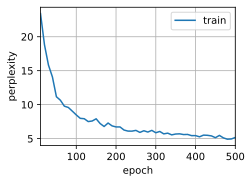

In [870]:
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
# device = device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(device)
num_epochs, lr = 500, 1
is_bidirectional = True
# gru = ParallelLogMiniGRU(vocab_size, num_hiddens, device, init_gru_state)
gru = GRULauangeModel(vocab_size, vocab_size, num_hiddens, device, num_layers=1, bidirectional=is_bidirectional)
gru.to(device)

# model = RNNModelScratch(len(vocab), num_hiddens, device, init_gru_state, gru)
train_ch8(gru, train_iter, vocab, lr, num_epochs, device)

In [871]:
a = init_gru_state(3, 3, device)
print(a)
# a.unsqueeze(0).shape
a.shape

tensor([[[0., 0., 0.]],

        [[0., 0., 0.]],

        [[0., 0., 0.]]])


torch.Size([3, 1, 3])

In [872]:
gru = ParallelLogMiniGRU(vocab_size, num_hiddens, device)
isinstance(gru, nn.Module)

TypeError: ParallelLogMiniGRU.__init__() missing 1 required positional argument: 'init_state'

In [746]:
# a = torch.Size([1, 1, 1, 512])
a = torch.randn(1, 1, 1, 512)
a= a.reshape(2, 1,1, -1)
a.shape

torch.Size([2, 1, 1, 256])

In [810]:
a = torch.arange(24).reshape(3, 2, 4)
print(a)
a = a.permute(1, 0, 2)
a.reshape(-1, 4)

tensor([[[ 0,  1,  2,  3],
         [ 4,  5,  6,  7]],

        [[ 8,  9, 10, 11],
         [12, 13, 14, 15]],

        [[16, 17, 18, 19],
         [20, 21, 22, 23]]])


tensor([[ 0,  1,  2,  3],
        [ 8,  9, 10, 11],
        [16, 17, 18, 19],
        [ 4,  5,  6,  7],
        [12, 13, 14, 15],
        [20, 21, 22, 23]])